In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing data

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Thesis/df2_csv')

In [ ]:
df.drop(columns = ["Unnamed: 0"], inplace = True)

In [ ]:
df.value_counts("label")

label
0    2537
1    1285
dtype: int64

In [ ]:
X = df.iloc[:, 0 : 2]
y = df.iloc[:, -1]

# Oversampling

In [ ]:
pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import imblearn

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')

In [ ]:
X_over, y_over = oversample.fit_resample(X, y)

In [ ]:
y_over.value_counts()

1    2537
0    2537
Name: label, dtype: int64

In [ ]:
X_over["label"] = y_over

In [ ]:
X_over.head()

,A,B,label
0,the dough used for pancakes is thin,the dough used for pancakes is thick,1
1,she showed him my ugly picture,she showed him my handsome picture,1
2,i only need the healthy half,i only need the bad half,1
3,i cant confidently tell you yet,i cant diffidently tell you yet,1
4,i need to be sure,i do not need to be sure,1


In [ ]:
df_balanced = X_over

# Creating Datasets object

In [ ]:
!pip install datasets
from datasets import Dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 5.8 MB/s 
     |████████████████████████████████| 140 kB 51.2 MB/s 
     |████████████████████████████████| 1.1 MB 9.0 MB/s 
     |████████████████████████████████| 101 kB 3.8 MB/s 
     |████████████████████████████████| 212 kB 8.6 MB/s 
     |████████████████████████████████| 596 kB 51.5 MB/s 
     |████████████████████████████████| 127 kB 51.6 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 59.2 MB/s 
     |████████████████████████████████| 271 kB 73.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's depend

In [ ]:
import pandas as pd
# df_balanced.to_csv("/content/drive/MyDrive/Thesis/df_balanced.csv")
df_balanced = pd.read_csv("/content/drive/MyDrive/Thesis/df_balanced.csv")

In [ ]:
dataset = Dataset.from_pandas(df_balanced)

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset('csv', data_files={'train': "/content/drive/MyDrive/Thesis/df_balanced.csv", 'test': '/content/drive/MyDrive/Thesis/test_df2_csv'})

Using custom data configuration default-1692bced3a4a3aa1


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1692bced3a4a3aa1/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# Tokenization

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.9 MB/s 
     |████████████████████████████████| 6.6 MB 15.3 MB/s 


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(examples):
  return tokenizer(examples["A"], examples["B"], padding = "max_length", truncation = True)
  
tokenized_datasets = dataset.map(tokenize_function, batched = True)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Parameter 'function'=<function tokenize_function at 0x7f363fbf3c20> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [ ]:
# small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
# small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [ ]:
train_data = tokenized_datasets["train"].remove_columns(["Unnamed: 0", "A", "B"])
test_data = tokenized_datasets["test"].remove_columns(["Unnamed: 0", "A", "B"])

In [ ]:
print(train_data)
print(test_data)

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5074
})
Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3513
})


In [ ]:
# small_eval_dataset = small_eval_dataset.remove_columns(["A", "B"])

# Model definition

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

# Training Arguments

In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments(output_dir = "/content/drive/MyDrive/Thesis/args_balanced_new")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


# Metrics

In [ ]:
import numpy as np
from datasets import load_metric
metric = load_metric("accuracy")

In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis = 1)
  return metric.compute(predictions = predictions, references = labels)

In [ ]:
from transformers import TrainingArguments, Trainer

# training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5074
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1905


Step,Training Loss
500,0.351500
1000,0.200900
1500,0.113100


Saving model checkpoint to /content/drive/MyDrive/Thesis/args_balanced/checkpoint-500
Configuration saved in /content/drive/MyDrive/Thesis/args_balanced/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/Thesis/args_balanced/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/Thesis/args_balanced/checkpoint-1000
Configuration saved in /content/drive/MyDrive/Thesis/args_balanced/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/Thesis/args_balanced/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/Thesis/args_balanced/checkpoint-1500
Configuration saved in /content/drive/MyDrive/Thesis/args_balanced/checkpoint-1500/config.json
Model weights saved in /content/drive/MyDrive/Thesis/args_balanced/checkpoint-1500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1905, training_loss=0.18873087665227453, metrics={'train_runtime': 1503.6858, 'train_samples_per_second': 10.123, 'train_steps_per_second': 1.267, 'total_flos': 4005076484689920.0, 'train_loss': 0.18873087665227453, 'epoch': 3.0})

# Calculating classification metrics

In [ ]:
tokenized_datasets["test"]

Dataset({
    features: ['Unnamed: 0', 'A', 'B', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3513
})

In [ ]:
datapoint = tokenized_datasets["test"].remove_columns(["A", "B", "label"])

In [ ]:
datapoint

Dataset({
    features: ['Unnamed: 0', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3513
})

In [ ]:
predictions = trainer.predict(datapoint)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0. If Unnamed: 0 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3513
  Batch size = 8


In [ ]:
len(predictions[0])

3513

In [ ]:
predict = np.array(predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
predict_label = predict[0].argmax(axis = 1)
predict_label

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
test_df2 = pd.read_csv("/content/drive/MyDrive/Thesis/test_df2_csv")

In [ ]:
label_arr = np.array(test_df2["label"])

In [ ]:
label_arr

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

In [ ]:
metrics = precision_recall_fscore_support(label_arr, predict_label, labels = [1, 0], pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None, zero_division='warn')

In [ ]:
F1 = f1_score(label_arr, predict_label, pos_label=1)

In [ ]:
F1

0.821138211382114

In [ ]:
metrics

(array([0.8015873 , 0.95865071]),
 array([0.84166667, 0.94629431]),
 array([0.82113821, 0.95243243]),
 array([ 720, 2793]))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
CF = confusion_matrix(label_arr, predict_label)

In [ ]:
CF

array([[2643,  150],
       [ 114,  606]])

In [ ]:
cd "/content/drive/MyDrive/Thesis/Images"

/content/drive/MyDrive/Thesis/Images


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [ ]:
plt.style.use('fivethirtyeight')
labels = ["Contradiction", "Not-Contradiction"]
x_indexes = [0, 1]
y_indexes = np.arange(0, 1.1, 0.1)
width = [0.25, 0.25]

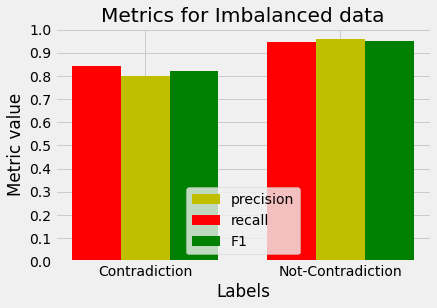

In [ ]:
plt.bar([0, 1], metrics[0], color = 'y', label = 'precision', width = width)
plt.bar([-0.25, 0.75], metrics[1], color = 'r', label = 'recall', width = width)
plt.bar([0.25, 1.25], metrics[2], color = 'g', label = 'F1', width = width)
plt.title("Metrics for Balanced data")
plt.xlabel("Labels")
plt.ylabel("Metric value")
plt.xticks(ticks = x_indexes, labels = labels)
plt.yticks(ticks = y_indexes)
plt.grid(True)
plt.legend()
plt.savefig("Balanced2_metrics.png")
plt.show()

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
  
# CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
  

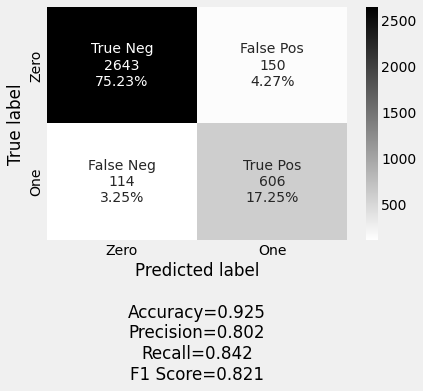

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(CF, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

# Comparison 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd "/content/drive/MyDrive/Thesis/Images"

/content/drive/MyDrive/Thesis/Images


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [ ]:
plt.style.use('fivethirtyeight')
labels = ["Contradiction", "Not-Contradiction"]
x_indexes = [0, 1]
y_indexes = np.arange(0, 1.1, 0.1)
width = 0.25

In [ ]:
metrics_balanced = (np.array([0.8015873 , 0.95865071]),#precision
 np.array([0.84166667, 0.94629431]),#recall 
 np.array([0.82113821, 0.95243243]),#F1
 np.array([ 720, 2793]))

In [ ]:
metrics_imbalanced = (np.array([0.87590188, 0.95992908]),
 np.array([0.84305556, 0.96920874]),
 np.array([0.8591649 , 0.96454659]),
 np.array([ 720, 2793]))

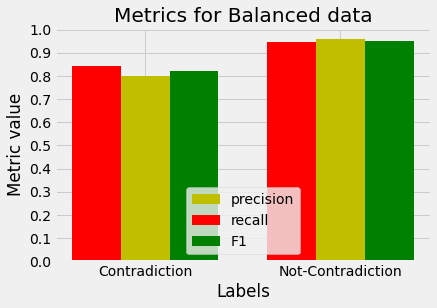

In [ ]:
plt.bar([0, 1], metrics_balanced[0], color = 'y', label = 'precision', width = width)
plt.bar([-0.25, 0.75], metrics[1], color = 'r', label = 'recall', width = width)
plt.bar([0.25, 1.25], metrics[2], color = 'g', label = 'F1', width = width)
plt.title("Metrics for Balanced data")
plt.xlabel("Labels")
plt.ylabel("Metric value")
plt.xticks(ticks = x_indexes, labels = labels)
plt.yticks(ticks = y_indexes)
plt.grid(True)
plt.legend()
plt.savefig("Balanced.png")
plt.show()